In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.transform import AffineTransform
from scipy.optimize import least_squares

Performing block matching...
Estimating affine transformation...


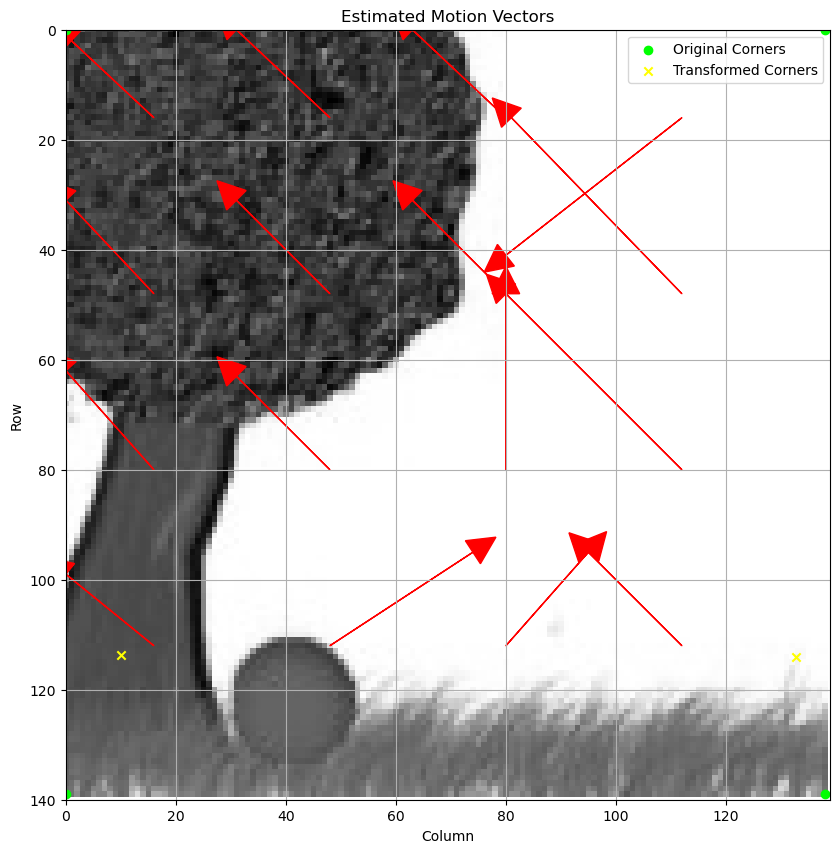


Estimated Affine Transformation Matrix:
[[ 8.89843750e-01  2.21093750e-01 -2.07875000e+01]
 [ 2.34374824e-03  8.86718748e-01 -9.58749974e+00]]


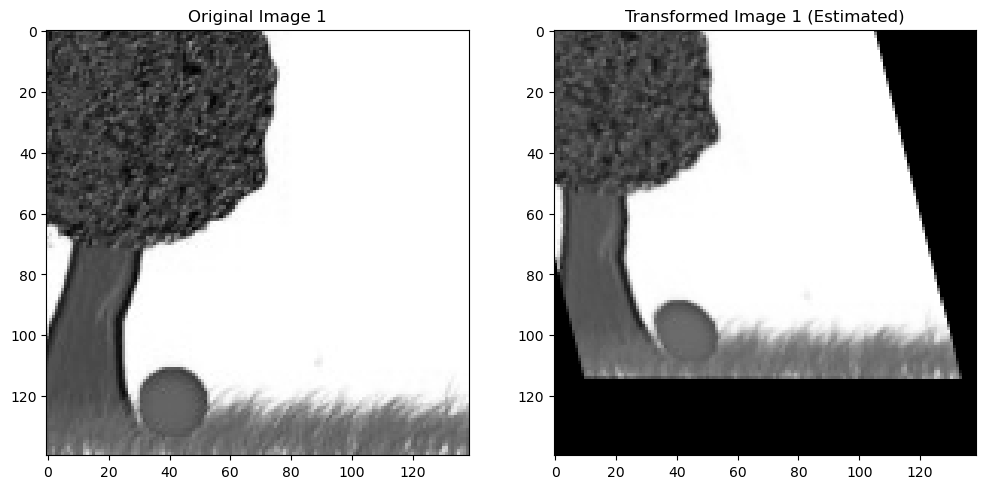

In [3]:
# Load the two images
img1 = cv2.imread('frame_1.jpg')
img2 = cv2.imread('frame_2.jpg')

if img1 is None or img2 is None:
    print("Error: Could not load one or both images.")
else:
    grayscale = True
    if grayscale:
        img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    else:
        img1_gray = img1
        img2_gray = img2

    block_size = 32
    search_window_size = 64

    # Create blocks in the first image
    blocks_data = []
    height, width = img1_gray.shape
    for row in range(0, height - block_size + 1, block_size):
        for col in range(0, width - block_size + 1, block_size):
            block = img1_gray[row:row + block_size, col:col + block_size]
            blocks_data.append((block, (row, col)))

    src_points_list = [coord + np.array([block_size // 2, block_size // 2]) for _, coord in blocks_data] # Center of the blocks
    src_points = np.array([coord[::-1] for coord in src_points_list]) # Convert to (x, y)

    dst_points_list = []
    displacements = []

    print("Performing block matching...")
    for block, (row, col) in blocks_data:
        min_ssd = float('inf')
        best_match_dy = 0
        best_match_dx = 0

        search_center = (row + block_size // 2, col + block_size // 2)
        target_height, target_width = img2_gray.shape
        block_height, block_width = block.shape

        search_row_start = max(0, search_center[0] - search_window_size // 2)
        search_row_end = min(target_height - block_height, search_center[0] + search_window_size // 2)
        search_col_start = max(0, search_center[1] - search_window_size // 2)
        search_col_end = min(target_width - block_width, search_center[1] + search_window_size // 2)

        for s_row in range(search_row_start, search_row_end + 1):
            for s_col in range(search_col_start, search_col_end + 1):
                target_block = img2_gray[s_row:s_row + block_height, s_col:s_col + block_width]
                ssd = np.sum((block.astype(float) - target_block.astype(float)) ** 2)
                if ssd < min_ssd:
                    min_ssd = ssd
                    best_match_dy = s_row - search_center[0]
                    best_match_dx = s_col - search_center[1]

        displacements.append((best_match_dy, best_match_dx))
        dst_points_list.append((col + block_size // 2 + best_match_dx, row + block_size // 2 + best_match_dy))

    dst_points = np.array(dst_points_list)

    # Estimate the affine transformation
    print("Estimating affine transformation...")
    if len(src_points) < 3 or len(dst_points) < 3:
        print("Error: At least 3 corresponding points are needed to estimate affine transformation.")
        affine_matrix = None
    else:
        def residuals(params, src, dst):
            """Calculates the residuals for least squares optimization."""
            a, b, c, d, e, f = params
            transformed_x = a * src[:, 0] + b * src[:, 1] + c
            transformed_y = d * src[:, 0] + e * src[:, 1] + f
            return np.concatenate((transformed_x - dst[:, 0], transformed_y - dst[:, 1]))

        initial_guess = np.array([1, 0, 0, 0, 1, 0])  # Identity transformation
        result = least_squares(residuals, initial_guess, args=(src_points, dst_points))

        if result.success:
            a, b, c, d, e, f = result.x
            affine_matrix = np.array([[a, b, c],
                                      [d, e, f]])
        else:
            print(f"Error: Least squares optimization failed: {result.message}")
            affine_matrix = None

    # Visualize the motion vectors
    plt.figure(figsize=(10, 10))
    plt.imshow(img1_gray, cmap='gray')
    height, width = img1_gray.shape

    for i, (row, col) in enumerate([coord for _, coord in blocks_data]):
        dy, dx = displacements[i]
        plt.arrow(col + block_size // 2, row + block_size // 2, dx, dy,
                  head_width=5, head_length=5, fc='r', ec='r')

    if affine_matrix is not None:
        # Visualize the transformation by showing how the corners of the image move
        corners = np.array([[0, 0, 1],
                            [width - 1, 0, 1],
                            [0, height - 1, 1],
                            [width - 1, height - 1, 1]])
        transformed_corners = (affine_matrix @ corners.T).T
        plt.scatter(corners[:, 0], corners[:, 1], color='lime', marker='o', label='Original Corners')
        plt.scatter(transformed_corners[:, 0], transformed_corners[:, 1], color='yellow', marker='x', label='Transformed Corners')
        plt.legend()

    plt.title("Estimated Motion Vectors")
    plt.xlabel("Column")
    plt.ylabel("Row")
    plt.xlim(0, width)
    plt.ylim(height, 0)  # Invert y-axis for image coordinates
    plt.grid(True)
    plt.show()

    if affine_matrix is not None:
        print("\nEstimated Affine Transformation Matrix:")
        print(affine_matrix)

        # Optional: Apply the estimated transformation to the first image and visualize
        transformed_img1 = cv2.warpAffine(img1_gray, affine_matrix, (width, height))

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(img1_gray, cmap='gray')
        plt.title('Original Image 1')
        plt.subplot(1, 2, 2)
        plt.imshow(transformed_img1, cmap='gray')
        plt.title('Transformed Image 1 (Estimated)')
        plt.show()
    else:
        print("Please make sure 'image1.png' and 'image2.png' exist in the same directory or provide the correct paths.")

So, what happened? Our motion estimation assumed the entire image was moving rather than tracking just the red ball. Let's try again using feature matching.

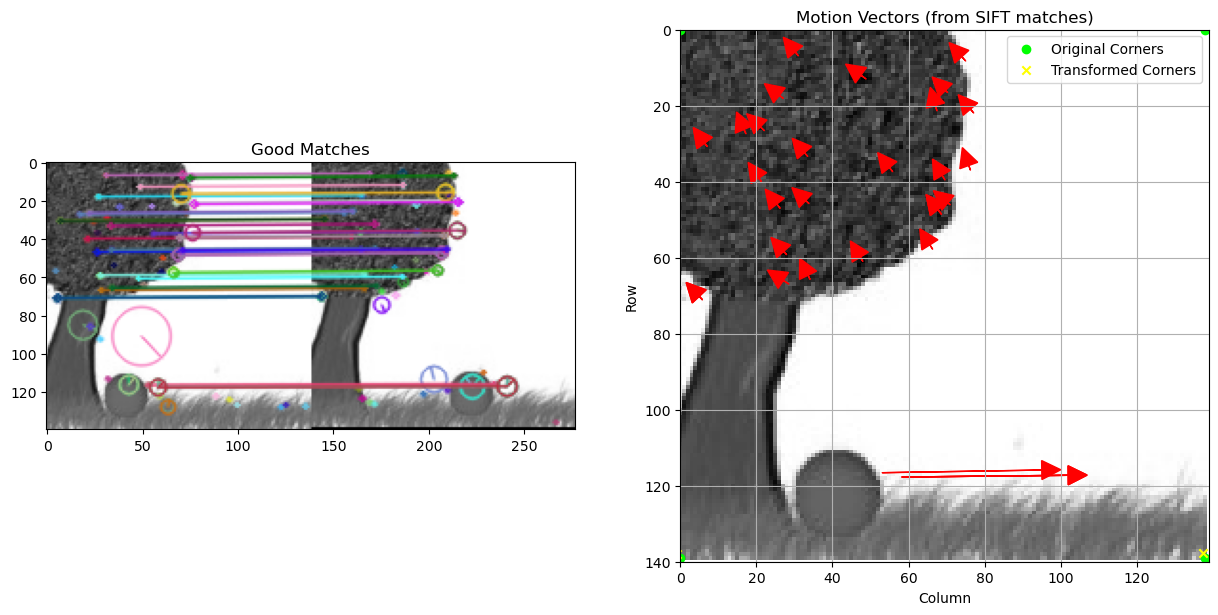


Estimated Affine Transformation Matrix (using SIFT):
[[ 1.00119405e+00  4.42850436e-04 -8.86331365e-01]
 [-2.19953070e-03  9.99376209e-01 -9.03701464e-01]]


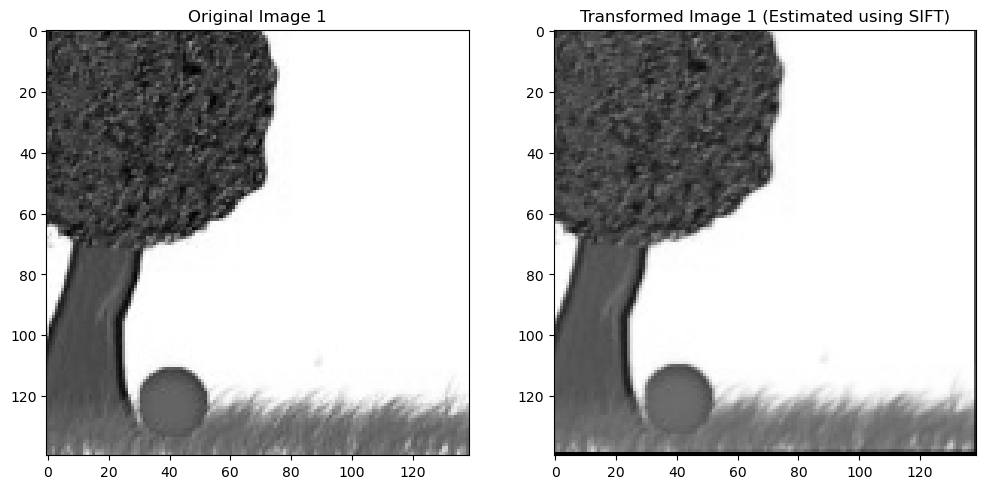

In [6]:
# Load the two images
img1 = cv2.imread('frame_1.jpg')
img2 = cv2.imread('frame_2.jpg')

if img1 is None or img2 is None:
    print("Error: Could not load one or both images.")
else:
    grayscale = True
    if grayscale:
        img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    else:
        img1_gray = img1
        img2_gray = img2

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Find keypoints and descriptors in both images
    keypoints1, descriptors1 = sift.detectAndCompute(img1_gray, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2_gray, None)

    if descriptors1 is None or descriptors2 is None or len(descriptors1) < 3 or len(descriptors2) < 3:
        print("Error: Not enough keypoints detected in one or both images.")
        affine_matrix = None
    else:
        # Use a brute-force matcher to find corresponding keypoints
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(descriptors1, descriptors2, k=2)

        # Apply ratio test to filter good matches
        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)

        if len(good_matches) < 3:
            print("Error: Not enough good matches found to estimate affine transformation.")
            affine_matrix = None
        else:
            # Extract corresponding points
            src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

            # Estimate affine transformation using RANSAC for robustness
            affine_matrix, mask = cv2.estimateAffine2D(src_pts, dst_pts, cv2.RANSAC, ransacReprojThreshold=5.0)

            if affine_matrix is None:
                print("Error: Failed to estimate affine transformation.")

    # Visualize the matches and the estimated motion
    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    img_matches = cv2.drawMatches(img1_gray, keypoints1, img2_gray, keypoints2, good_matches, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(img_matches, cmap='gray')
    plt.title('Good Matches')

    plt.subplot(1, 2, 2)
    plt.imshow(img1_gray, cmap='gray')
    plt.title('Motion Vectors (from SIFT matches)')

    if affine_matrix is not None and len(good_matches) > 0:
        for match in good_matches:
            pt1 = keypoints1[match.queryIdx].pt
            pt2 = keypoints2[match.trainIdx].pt
            plt.arrow(pt1[0], pt1[1], pt2[0] - pt1[0], pt2[1] - pt1[1],
                      head_width=5, head_length=5, fc='r', ec='r')

        # Visualize the transformation of image corners
        height, width = img1_gray.shape
        corners = np.array([[0, 0, 1],
                            [width - 1, 0, 1],
                            [0, height - 1, 1],
                            [width - 1, height - 1, 1]])
        transformed_corners = (affine_matrix @ corners.T).T
        plt.scatter(corners[:, 0], corners[:, 1], color='lime', marker='o', label='Original Corners')
        plt.scatter(transformed_corners[:, 0], transformed_corners[:, 1], color='yellow', marker='x', label='Transformed Corners')
        plt.legend()

    plt.xlabel("Column")
    plt.ylabel("Row")
    plt.xlim(0, img1_gray.shape[1])
    plt.ylim(img1_gray.shape[0], 0)
    plt.grid(True)
    plt.show()

    if affine_matrix is not None:
        print("\nEstimated Affine Transformation Matrix (using SIFT):")
        print(affine_matrix)

        # Optional: Apply the estimated transformation to the first image and visualize
        height, width = img1_gray.shape
        transformed_img1 = cv2.warpAffine(img1_gray, affine_matrix, (width, height))

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(img1_gray, cmap='gray')
        plt.title('Original Image 1')
        plt.subplot(1, 2, 2)
        plt.imshow(transformed_img1, cmap='gray')
        plt.title('Transformed Image 1 (Estimated using SIFT)')
        plt.show()
    else:
        print("Please make sure 'image1.png' and 'image2.png' exist in the same directory or provide the correct paths and that enough SIFT features were detected and matched.")

Way better. Our little ball is zooming along. Now let's predict where it will be in frame 3.


Estimated Affine Transformation Matrix:
[[ 1.00119405e+00  4.42850436e-04 -8.86331365e-01]
 [-2.19953070e-03  9.99376209e-01 -9.03701464e-01]]


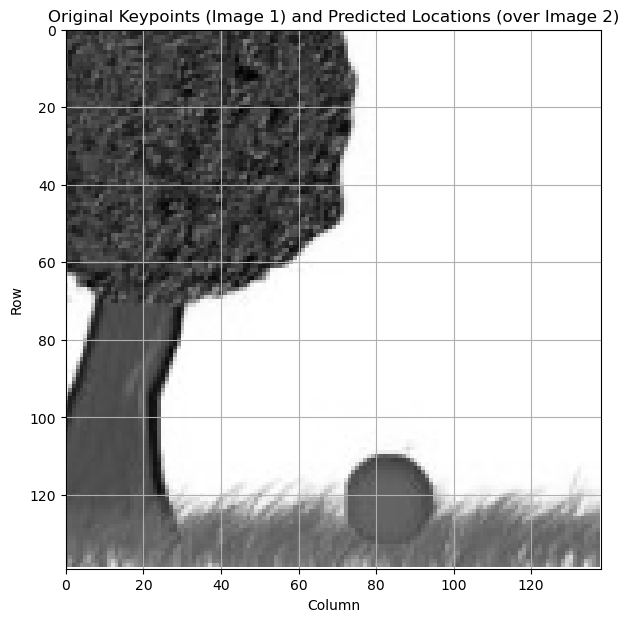

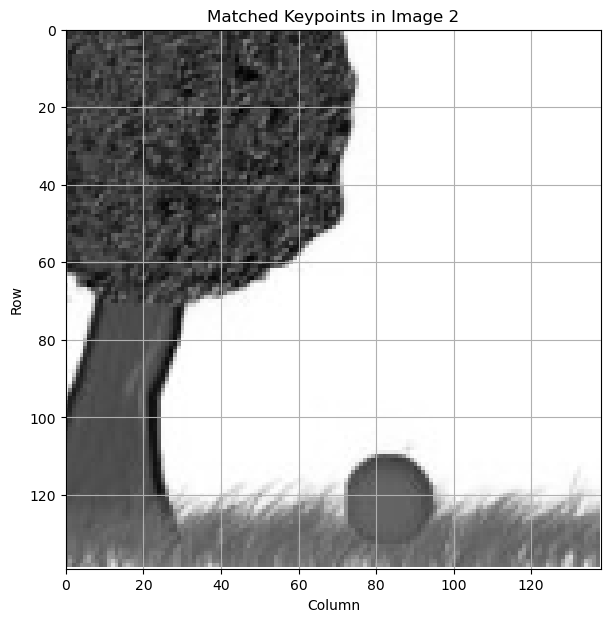

In [5]:
# Load the two images
img1 = cv2.imread('frame_1.jpg')
img2 = cv2.imread('frame_2.jpg')
if img1 is None or img2 is None:
    print("Error: Could not load one or both images.")
else:
    grayscale = True
    if grayscale:
        img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    else:
        img1_gray = img1
        img2_gray = img2

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Find keypoints and descriptors in the first image
    keypoints1, descriptors1 = sift.detectAndCompute(img1_gray, None)

    if descriptors1 is None or len(descriptors1) < 3:
        print("Error: Not enough keypoints detected in the first image.")
        predicted_keypoints = None
        affine_matrix = None
    else:
        # Find keypoints and descriptors in the second image
        keypoints2, descriptors2 = sift.detectAndCompute(img2_gray, None)

        if descriptors2 is None or len(descriptors2) < 3:
            print("Error: Not enough keypoints detected in the second image.")
            predicted_keypoints = None
            affine_matrix = None
        else:
            # Use a brute-force matcher to find corresponding keypoints
            bf = cv2.BFMatcher()
            matches = bf.knnMatch(descriptors1, descriptors2, k=2)

            # Apply ratio test to filter good matches
            good_matches = []
            for m, n in matches:
                if m.distance < 0.75 * n.distance:
                    good_matches.append(m)

            if len(good_matches) < 3:
                print("Error: Not enough good matches found to estimate affine transformation.")
                predicted_keypoints = None
                affine_matrix = None
            else:
                # Extract corresponding points
                src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
                dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

                # Estimate affine transformation using RANSAC
                affine_matrix, mask = cv2.estimateAffine2D(src_pts, dst_pts, cv2.RANSAC, ransacReprojThreshold=5.0)

                if affine_matrix is None:
                    print("Error: Failed to estimate affine transformation.")
                    predicted_keypoints = None
                else:
                    # Predict the location of all keypoints from the first image in the next frame
                    predicted_keypoints = []
                    for kp in keypoints1:
                        x, y = kp.pt
                        # Apply the affine transformation [a b c; d e f]
                        transformed_x = affine_matrix[0, 0] * x + affine_matrix[0, 1] * y + affine_matrix[0, 2]
                        transformed_y = affine_matrix[1, 0] * x + affine_matrix[1, 1] * y + affine_matrix[1, 2]
                        predicted_keypoints.append((transformed_x, transformed_y))

                    print("\nEstimated Affine Transformation Matrix:")
                    print(affine_matrix)

                    # Visualize the original keypoints and their predicted locations
                    plt.figure(figsize=(10, 7))
                    plt.imshow(img2_gray, cmap='gray')
                    plt.title('Original Keypoints (Image 1) and Predicted Locations (over Image 2)')

                    # Draw original keypoints (e.g., in blue)
                    for kp in keypoints1:
                        cv2.circle(img2, (int(kp.pt[0]), int(kp.pt[1])), 3, (255, 0, 0), -1) # Blue

                    # Draw predicted keypoint locations (e.g., in red)
                    for pred_pt in predicted_keypoints:
                        cv2.circle(img2, (int(pred_pt[0]), int(pred_pt[1])), 3, (0, 0, 255), -1) # Red

                    plt.xlabel("Column")
                    plt.ylabel("Row")
                    plt.xlim(0, img2_gray.shape[1])
                    plt.ylim(img2_gray.shape[0], 0)
                    plt.grid(True)
                    plt.show()

                    # Visualize the matched keypoints in the second image (e.g., in green)
                    if len(good_matches) > 0:
                        plt.figure(figsize=(10, 7))
                        plt.imshow(img2_gray, cmap='gray')
                        plt.title('Matched Keypoints in Image 2')
                        for match in good_matches:
                            pt2 = keypoints2[match.trainIdx].pt
                            cv2.circle(img2, (int(pt2[0]), int(pt2[1])), 3, (0, 255, 0), -1) # Green
                        plt.xlabel("Column")
                        plt.ylabel("Row")
                        plt.xlim(0, img2_gray.shape[1])
                        plt.ylim(img2_gray.shape[0], 0)
                        plt.grid(True)
                        plt.show()

        if affine_matrix is None:
            print("Affine transformation was not successfully estimated, so keypoint prediction is not possible.")